In [97]:
import string
import re
import warnings
import requests
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
warnings.filterwarnings(action='once')
pd.options.display.max_columns = 40

In [98]:
%%time
articles = pd.read_csv(
    './data/articles_prep.csv', 
    delimiter=';'
)
articles = articles.dropna(
    subset=['time_stamp', 'company', 'title', 'text']
)#.head(1000)

display(articles)

punctuation = string.punctuation
punctuation += '•€'

stop_words = stopwords.words('english')

,company,time_stamp,title,length,text
0,commerzbank ag,2019-03-04,Commerzbank AG Post-stab Berlin 0.625% EUR 250...,229.0,Post-stabilisation notice 4 March 2019 Not for...
1,ks ag,2021-02-15,DGAP-Adhoc: DEPFA BANK plc: FMS-WM announces s...,292.0,DGAP-Ad-hoc: DEPFA BANK plc / Key word(s): Mis...
2,morphosys ag,2022-01-06,"INTERNATIONAL PATENT: MORPHOSYS AG, GILEAD SCI...",224.0,"GENEVA, Jan. 6 -- MORPHOSYS AG (Semmelweisstr...."
3,ks ag,2020-03-24,DGAP-Adhoc: Delignit AG: Delignit responds to ...,555.0,Delignit AG: Delignit responds to COVID-19 pan...
5,gea group ag,2018-05-04,DGAP-News: GEA Group Aktiengesellschaft: GEA a...,1047.0,GEA Group Aktiengesellschaft: GEA announces fi...
...,...,...,...,...,...
22389,lanxess ag,2019-02-01,-LANXESS - High-performance prepolymer technol...,690.0,Cologne - Specialty chemicals company LANXESS ...
22390,secunet security networks ag,2020-08-12,DGAP-News: secunet Security Networks AG closes...,1122.0,secunet Security Networks AG closes first half...
22391,dic asset ag,2022-09-19,EQS-News: DIC Asset AG renews leases for about...,847.0,EQS-News: DIC Asset AG / Key word(s): Real Est...
22392,deutz ag,2022-08-11,Deutz AG Half Year Results,1678.0,RNS Number : 6878V Deutz AG 11 August 2022 * O...


CPU times: user 1.21 s, sys: 541 ms, total: 1.75 s
Wall time: 2.25 s


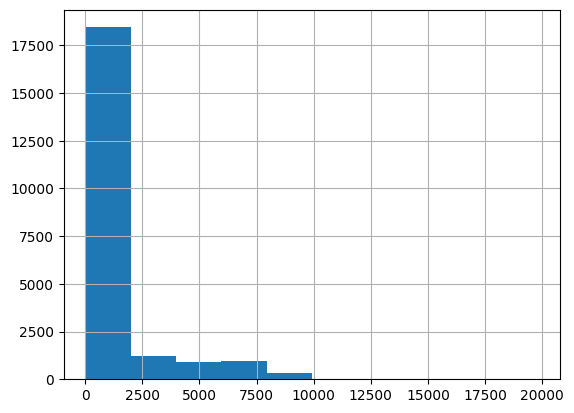

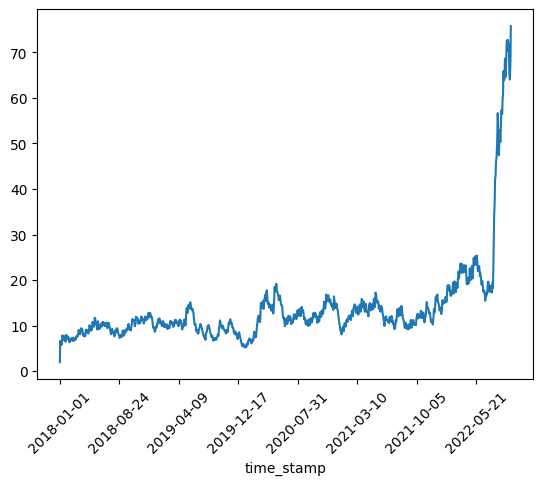

CPU times: user 539 ms, sys: 180 ms, total: 719 ms
Wall time: 304 ms


In [99]:
%%time
%%capture --no-display
articles['length'].hist()
plt.show()
#articles = articles[articles['length'] < 2000]
#articles['length'].hist()


"""
articles_string = articles['text'].to_list()
articles_string = ' '.join(articles_string)
articles_string = articles_string.lower()
articles_string = articles_string.translate(str.maketrans('', '', punctuation))
articles_string = ' '.join(articles_string.split())

wordcloud = WordCloud(width=2000, height=1000)
wordcloud.generate(articles_string)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
"""

articles.groupby('time_stamp')['text'].count().ewm(halflife=10).mean().plot()
plt.xticks(rotation = 45)
plt.show()

In [100]:
%%time
lemmatizer = WordNetLemmatizer()

def map_postag(word):
    if word == 'NOUN':
        return 'n'
    elif word == 'VERB':
        return 'v'
    elif word == 'ADJ':
        return 'a'
    elif word == 'ADV':
        return 'r'
    else:
        return 'n'

def preprocessor(X):
    # to lower
    X = X.lower()
    # punctuation
    X = X.translate(str.maketrans('', '', punctuation))
    # remove multi white space
    X = ' '.join(X.split())
    
    return X

def tokenizer(X):
    # tokenize
    X = word_tokenize(X, language='english')
    # pos tag
    X = pos_tag(X, tagset='universal')
    X = [(s[0], map_postag(s[1])) for s in X]
    # remove strange words
    q = [r'(.)\1\1', r'\d', 'www', 'http']
    X = [s for s in X if not any([bool(re.search(x, s[0])) for x in q])]
    X = [s for s in X if len(s[0]) < 20]
    # stopwords
    X = [s for s in X if len(s[0]) > 2]
    X = [s for s in X if not s[0] in stop_words]
    # lemmatize
    X = [lemmatizer.lemmatize(s[0], pos=s[1]) for s in X]
    
    return X

vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    max_df=0.5,
    min_df=2,
    #ngram_range=(1,3)
)

X = vectorizer.fit_transform(articles['text'])
tokens = articles['text'].apply(vectorizer.build_analyzer()).to_list()

CPU times: user 31min 25s, sys: 6.21 s, total: 31min 31s
Wall time: 31min 33s


In [50]:
%%time
topic_coherence = list()

for t in range(1, 12):
    lda_model = LatentDirichletAllocation(
        n_components=t,
    )
    lda_model.fit(X)

    coherence = metric_coherence_gensim(
        measure='c_v',
        top_n=25,
        topic_word_distrib=lda_model.components_,
        vocab=vectorizer.get_feature_names_out(),
        dtm=X,
        texts=tokens,
        return_mean=True
    )
    
    topic_coherence.append([t, coherence])
    
topic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence_score'])

CPU times: user 1h 8min 44s, sys: 23min 1s, total: 1h 31min 46s
Wall time: 31min 10s


<AxesSubplot:xlabel='n_topics'>

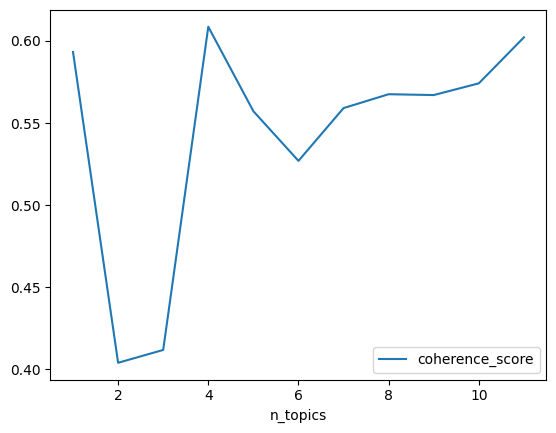

In [51]:
topic_coherence.plot(x='n_topics', y='coherence_score')

In [101]:
lda_model = LatentDirichletAllocation(
    n_components=4,
)
lda_model.fit(X)

LatentDirichletAllocation(n_components=4)

In [75]:
%%capture --no-display
#pyLDAvis.sklearn.prepare(lda_model, X, vectorizer)

In [102]:
doc_topic = lda_model.transform(X)
doc_topic = pd.DataFrame(
    doc_topic,
    columns=[f'topic_{i}' for i in range(1, doc_topic.shape[1]+1)]
)
display(doc_topic)

topic_size = (doc_topic.sum() / len(doc_topic)).to_frame().transpose()
display(topic_size)

topic_word = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
topic_word = pd.DataFrame(
    topic_word,
    index=[f'topic_{i}' for i in range(1, topic_word.shape[0]+1)],
    columns=vectorizer.get_feature_names_out()
).round(5)

for topic in topic_word.index:
    display(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].iloc[:, :10])

,topic_1,topic_2,topic_3,topic_4
0,0.003292,0.990849,0.002921,0.002939
1,0.068517,0.926636,0.002446,0.002401
2,0.107353,0.838277,0.051511,0.002859
3,0.001414,0.783678,0.213493,0.001415
4,0.000737,0.861908,0.101070,0.036285
...,...,...,...,...
21885,0.000788,0.000837,0.997554,0.000821
21886,0.000555,0.998313,0.000555,0.000578
21887,0.000640,0.908584,0.039560,0.051216
21888,0.000402,0.700251,0.298923,0.000424


,topic_1,topic_2,topic_3,topic_4
0,0.158564,0.422654,0.255871,0.16291


,blackrock,right,inc,total,wphg,holding,vote,sec,holdco,limit
topic_1,0.05919,0.03314,0.0295,0.02176,0.019,0.01897,0.0186,0.01754,0.01732,0.01694


,million,eur,announcement,dgap,board,financial,result,revenue,increase,first
topic_2,0.01533,0.0141,0.00682,0.00593,0.00558,0.00549,0.00543,0.00534,0.00528,0.00527


,global,report,growth,product,industry,system,business,analysis,forecast,key
topic_3,0.00872,0.00826,0.00726,0.00702,0.00695,0.00629,0.0059,0.0054,0.00536,0.00489


,price,asset,total,change,eur,past,average,section,net,yield
topic_4,0.01657,0.01395,0.01154,0.01145,0.01138,0.01096,0.01089,0.01072,0.01059,0.01003


In [103]:
topic_activity = doc_topic.copy()
topic_activity['time_stamp'] = pd.to_datetime(articles['time_stamp'])
topic_activity['time_stamp'] = topic_activity['time_stamp'] - pd.to_timedelta((topic_activity['time_stamp'].dt.dayofweek - 4).clip(lower=0), unit='D')
topic_activity['time_stamp'] = topic_activity['time_stamp'].dt.date
topic_activity['company'] = articles['company']

topic_activity = topic_activity.groupby(['company', 'time_stamp']).apply(lambda x: x.sum()/len(x))

topic_activity = topic_activity.unstack(fill_value=0, level=0)
topic_activity.index = pd.to_datetime(topic_activity.index)
topic_activity = topic_activity.asfreq('D', fill_value=0)
topic_activity = topic_activity.stack(level=1)
topic_activity = topic_activity.swaplevel().sort_index()

# TODO handle news on weekend
topic_activity = topic_activity[topic_activity.index.get_level_values('time_stamp').dayofweek < 5]

topic_activity = topic_activity.ewm(halflife=5).mean()
display(topic_activity)

topic_activity.to_csv('data/topic_activity.csv', sep=';')

topic_1       topic_2       topic_3  \
company          time_stamp                                             
1&1 drillisch ag 2018-01-01  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-02  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-03  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-04  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-05  0.000000e+00  0.000000e+00  0.000000e+00   
...                                   ...           ...           ...   
zooplus ag       2022-09-26  5.673039e-16  6.211010e-15  3.539091e-14   
                 2022-09-27  4.938667e-16  5.406999e-15  3.080958e-14   
                 2022-09-28  4.299359e-16  4.707066e-15  2.682129e-14   
                 2022-09-29  3.742810e-16  4.097739e-15  2.334929e-14   
                 2022-09-30  3.258305e-16  3.567289e-15  2.032674e-14   

                                  topic_4  
company          time_stamp                
1&1 drillisch ag 2018-01-01  0.000000e+00  
                 2018-01-02  0.000000e+00  
                 2018-01-03  0.000000e+00  
                 2018-01-04  0.000000e+00  
                 2018-01-05  0.000000e+00  
...                                   ...  
zooplus ag       2022-09-26  1.359599e-14  
                 2022-09-27  1.183600e-14  
                 2022-09-28  1.030383e-14  
                 2022-09-29  8.970009e-15  
                 2022-09-30  7.808846e-15  

[146320 rows x 4 columns]

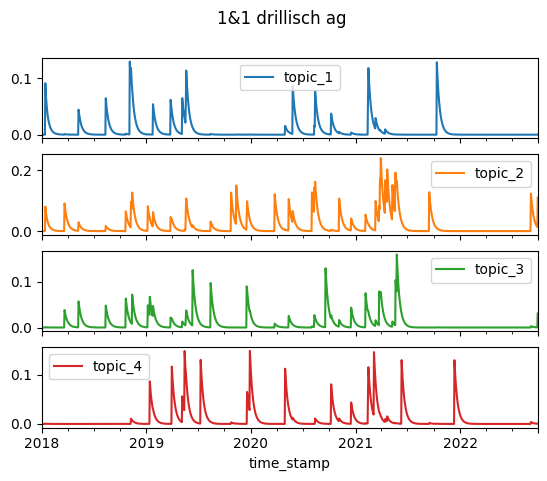

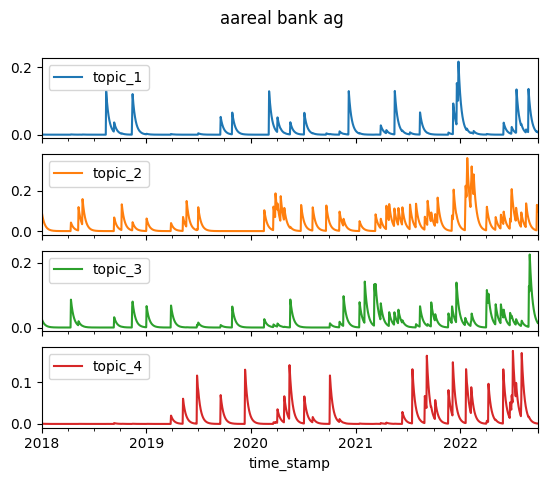

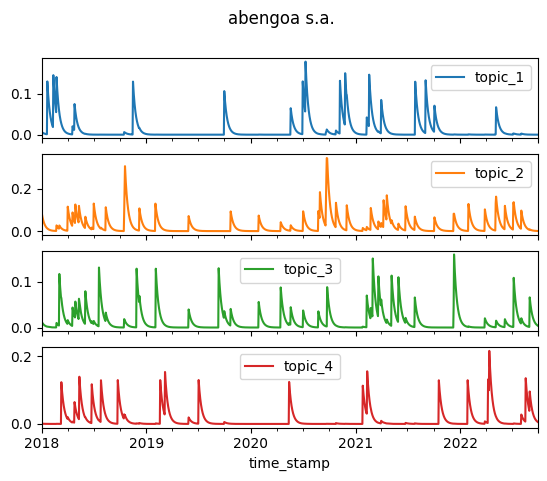

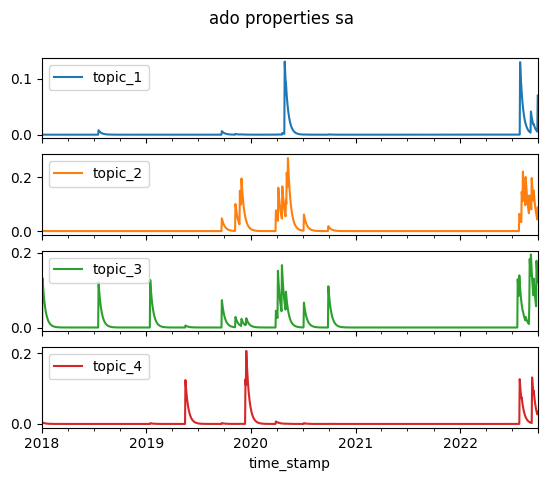

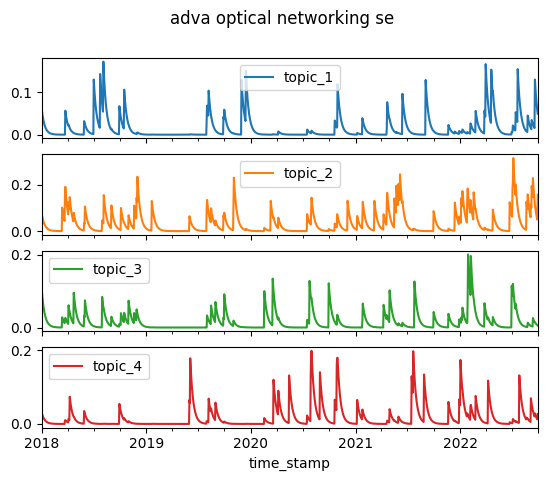

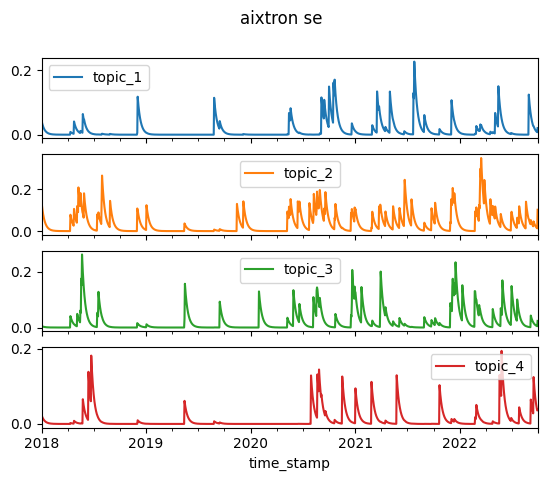

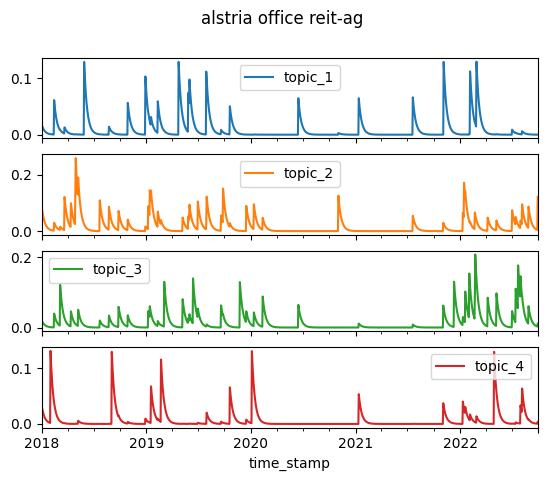

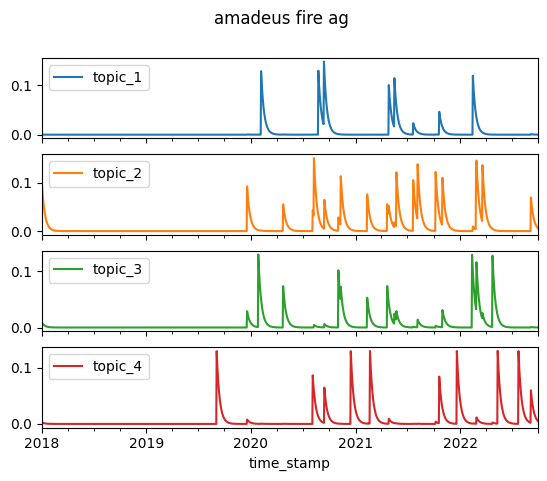

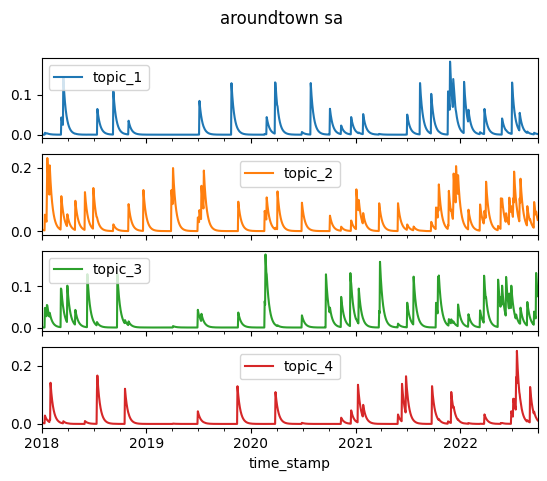

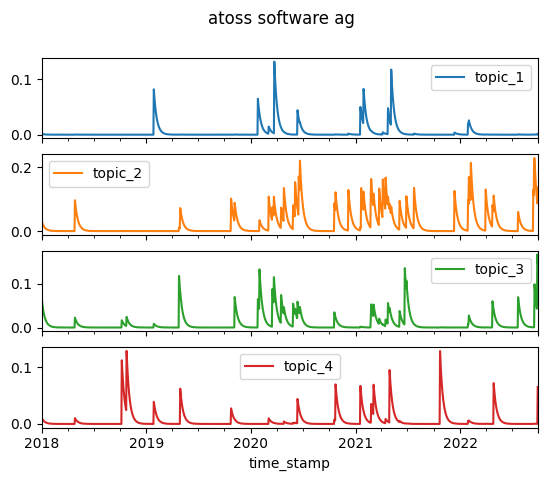

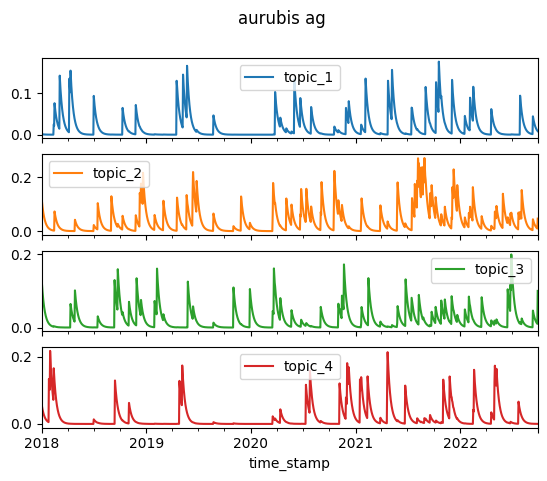

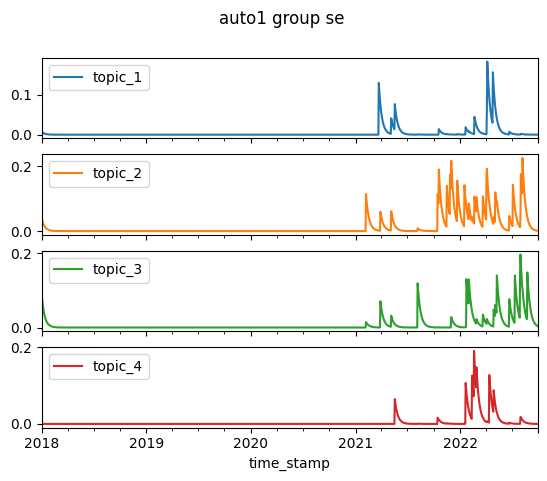

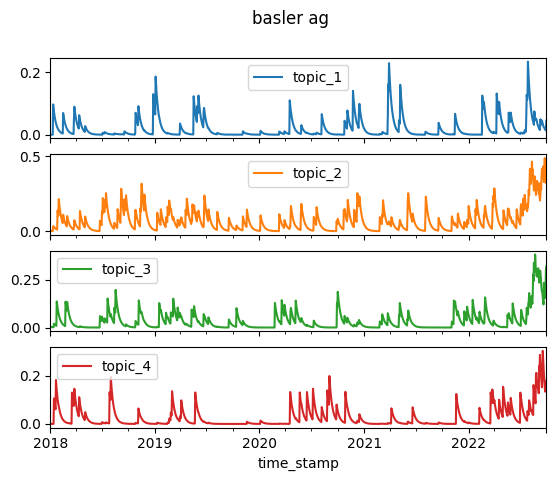

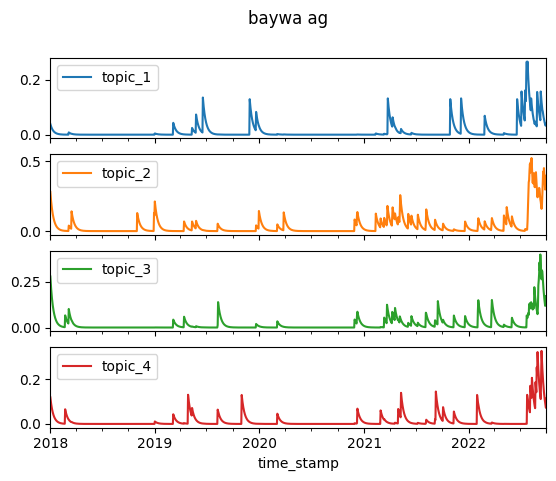

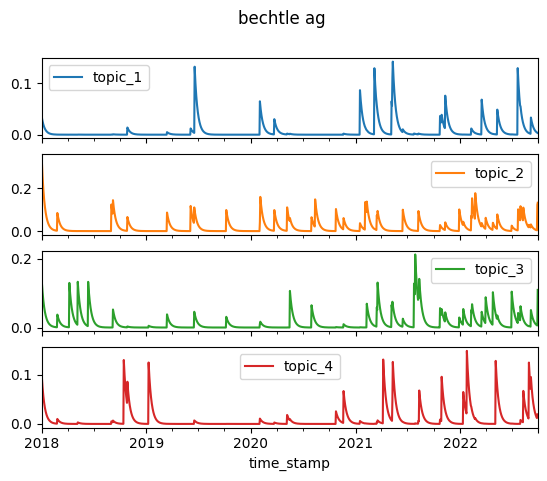

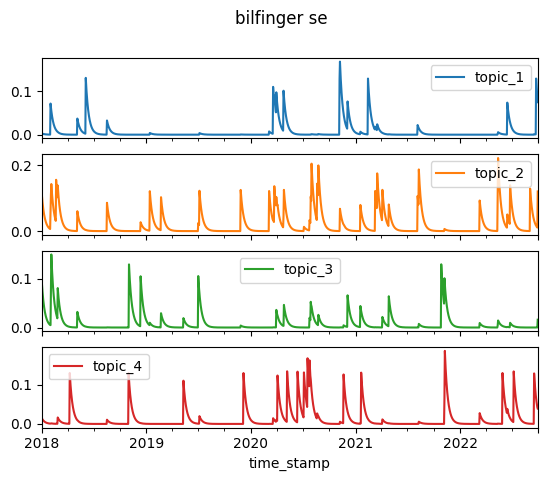

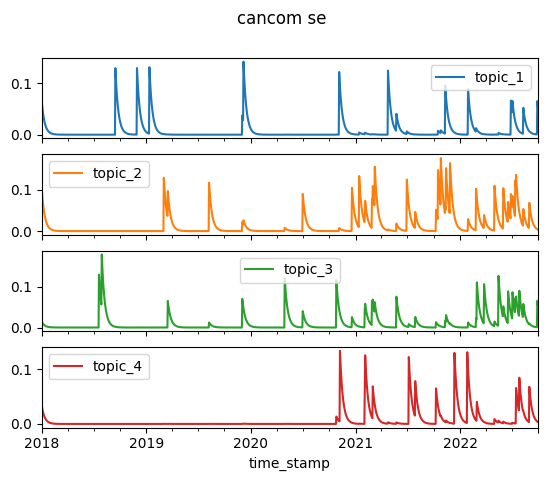

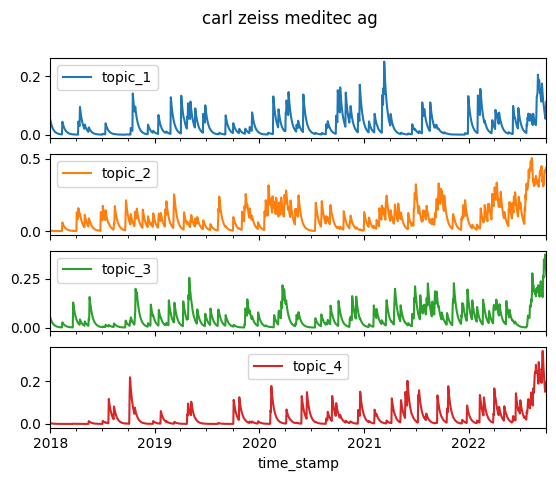

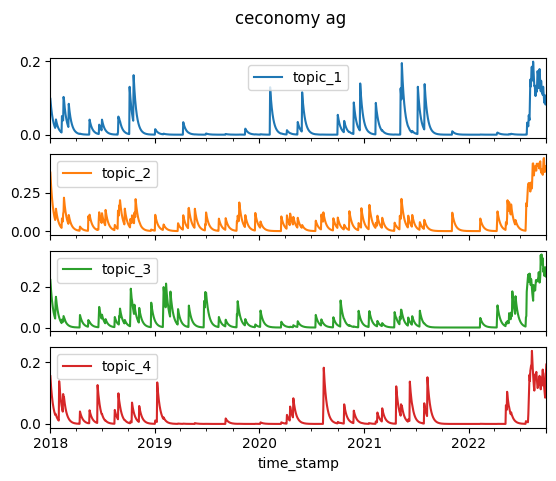

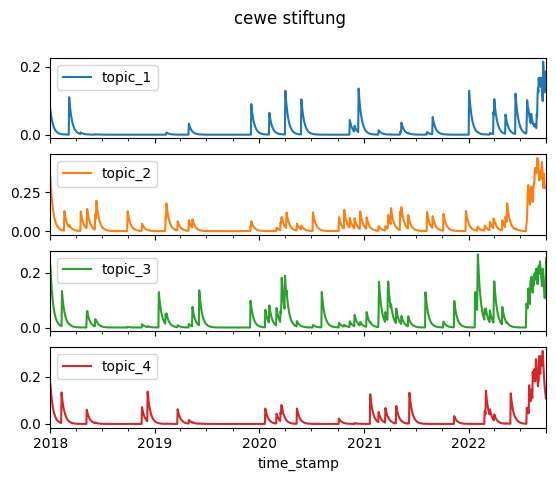

In [104]:
companys = sorted(list(set(topic_activity.index.get_level_values('company'))))

for i in range(20):
    topic_activity.loc[companys[i], :].plot(
        kind='line',
        title=companys[i],
        subplots=True
    )
    #plt.title(companys[i])
    plt.show()